# Clustering lynx

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

from tqdm import tqdm
from torchvision import models
from scipy.stats import norm
from gensim.models import Word2Vec
from sklearn.neighbors import NearestNeighbors
from oml.functional.metrics import calc_cmc, calc_map, calc_precision

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/gpfs7kro/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blo

In [3]:
random.seed(42)

In [4]:
# !pip install -U open-metric-learning --user --no-cache-dir
# !pip install gensim --user --no-cache-dir

## Load data

In [5]:
data = pd.read_csv("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv")
data

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-04-27,NaN,1,0.938,854.8416,1054.8000,558.8352,289.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-05-05,NaN,2,0.894,906.8544,948.9312,997.7472,1628.8128
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-17,NaN,3,0.939,1192.8384,821.8000,743.9040,465.8000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-16,NaN,4,0.965,834.8832,673.8000,594.8640,518.8000
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-05,NaN,5,0.970,765.9080,315.9860,568.8540,392.9500
...,...,...,...,...,...,...,...,...,...,...,...,...
3075,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,2,0.925,668.7360,1152.9216,3805.5744,2295.8208
3076,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3,0.949,1276.8192,880.9344,3906.6624,2475.8784
3077,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4,0.902,615.8804,767.9859,1334.8447,828.8511
3078,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,1,0.959,1797.7904,835.8592,470.8928,251.9680


### Load our best model to get embeddings from image

In [6]:
model_weights = torch.load("/gpfswork/rech/ads/commun/kg_tests/model_best_0.512.pth", map_location=torch.device('cpu'))
model = models.resnet50(pretrained=False)
model.fc = nn.Identity()
model.load_state_dict(model_weights)

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [7]:
# load dataset
from data_pipeline.dataset import LynxDataset
from pathlib import Path
from data_pipeline.transformations_and_augmentations import transforms

lynxDataset = LynxDataset(
    Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv"),
    loader="pil",
    transform=transforms,
)

(1024, 1024, 3)


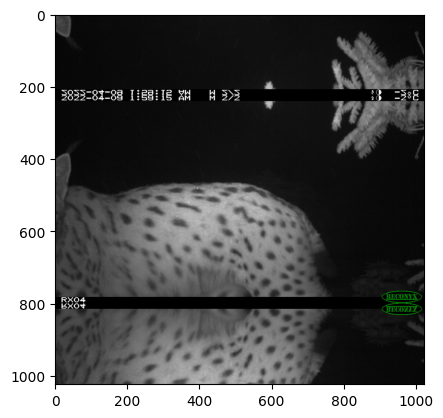

In [8]:
img = lynxDataset[100][0]['image']
print(img.shape)
plt.imshow(img)

### Selection of individuals

We are looking for individuals with around 10 images to test the evaluation metrics.

In [9]:
lynx_id_counts = data['lynx_id'].value_counts()
lynx_id_counts[70:100]

F25-039                   11
1277                      11
F25-053=1247              11
1276=1278                 11
1528=B811                 11
777                       11
2620                      11
1567                      10
F39-043                   10
1317                      10
F01-021                   10
F25-033                   10
F74-003                   10
1321                      10
243                        9
F01-008                    9
1068                       9
F39-025                    9
F01-031                    9
Leki                       9
F25-062=1050=1102=B704     9
1813                       9
1320                       9
1759                       8
2658                       8
2166                       8
1942                       8
1254                       8
Bingo                      8
2350                       7
Name: lynx_id, dtype: int64

In [10]:
lynx_id_counts[70:100].index.tolist()

['F25-039',
 '1277',
 'F25-053=1247',
 '1276=1278',
 '1528=B811',
 '777',
 '2620',
 '1567',
 'F39-043',
 '1317',
 'F01-021',
 'F25-033',
 'F74-003',
 '1321',
 '243',
 'F01-008',
 '1068',
 'F39-025',
 'F01-031',
 'Leki',
 'F25-062=1050=1102=B704',
 '1813',
 '1320',
 '1759',
 '2658',
 '2166',
 '1942',
 '1254',
 'Bingo',
 '2350']

In [11]:
selected_individuals = ["Leki", "1068", "243"]

In [12]:
data_selected_individuals = data[data["lynx_id"].isin(selected_individuals)]
data_selected_individuals = data_selected_individuals.copy()

In [13]:
# add an "unknown" candidate
new_individual = data.iloc[100].copy()
new_individual['lynx_id'] = "New"
data_selected_individuals = pd.concat([data_selected_individuals, new_individual.to_frame().T])

In [14]:
print(data_selected_individuals.shape)
data_selected_individuals

(28, 12)


,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
23,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,NaN,NaN,1,0.866,447.951,137.9448,382.93,357.9996
24,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2018-09-27,NaN,2,0.926,765.0,442.8996,413.85,275.9445
25,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2018-10-16,NaN,3,0.951,824.85,378.9555,235.95,158.928
26,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2018-04-15,NaN,4,0.968,516.8448,988.8,791.856,625.0
27,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2022-09-05,NaN,5,0.924,821.8624,408.924,268.9024,149.9388
28,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2018-11-25,NaN,6,0.94,288.9576,335.9232,433.9992,320.976
29,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,2015-02-14,NaN,7,0.92,639.9,173.9484,326.85,379.9688
30,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,NaN,NaN,8,0.952,733.0,233.9571,267.875,411.9663
31,/gpfsscratch/rech/ads/commun/datasets/extracte...,Leki,OCS,NaN,NaN,NaN,9,0.931,462.8952,150.9624,340.9844,386.9586
695,/gpfsscratch/rech/ads/commun/datasets/extracte...,1068,OFB,OCELLES,2017-09-28,La-Tour-du-Meix,1,0.967,405.9776,119.99232,1122.8784,1054.8928


In [15]:
indices_lynxDataset = data_selected_individuals.index.tolist()

In [16]:
# Compute batch
images = []
for individual_index in indices_lynxDataset:
    img = lynxDataset[individual_index][0]['image']
    img = img.transpose(2,0,1)
    img = torch.FloatTensor(img)

    images.append(img)
    
images = torch.stack(images, dim=0)
images.shape

torch.Size([28, 3, 1024, 1024])

### Compute all embeddings

In [17]:
with torch.no_grad():
    embeddings = model(images)
    
embeddings.shape

torch.Size([28, 2048])

In [18]:
embeddings

tensor([[0.1697, 0.1963, 0.1629,  ..., 0.0974, 0.2004, 0.1734],
        [0.1629, 0.2067, 0.1663,  ..., 0.1025, 0.1464, 0.1456],
        [0.1542, 0.2139, 0.1450,  ..., 0.1110, 0.1461, 0.1476],
        ...,
        [0.1527, 0.2305, 0.1754,  ..., 0.1134, 0.1520, 0.1967],
        [0.1751, 0.2514, 0.1456,  ..., 0.1150, 0.1681, 0.2420],
        [0.1175, 0.2262, 0.1877,  ..., 0.1020, 0.1670, 0.1058]])

### Dimension reduction and choice of candidates

In [19]:
lynx_str_to_int = {}
lynx_int_to_str = {}

for index, string in enumerate(selected_individuals):
    lynx_str_to_int[string] = index
    lynx_int_to_str[index] = string
    
print(lynx_str_to_int)
print(lynx_int_to_str)

{'Leki': 0, '1068': 1, '243': 2}
{0: 'Leki', 1: '1068', 2: '243'}


In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=20)
embeddings_2d = tsne.fit_transform(embeddings)

print(embeddings_2d.shape)

(28, 2)


In [21]:
if 'level_0' in data_selected_individuals.columns:
    data_selected_individuals.drop(['level_0'], axis=1, inplace=True)
data_selected_individuals.reset_index(inplace=True)
data_selected_individuals['embedding'] = list(map(list, embeddings_2d))
data_selected_individuals[['embedding_x', 'embedding_y']] = pd.DataFrame(embeddings_2d)
data_selected_individuals['lynx_id_int'], _ = pd.factorize(data_selected_individuals["lynx_id"])

In [22]:
def extract_random_rows(group, nb_to_extract=2):
    if group.shape[0] < nb_to_extract:
        return group
    return group.sample(n=nb_to_extract, replace=False)


data_candidates = data_selected_individuals.groupby('lynx_id', group_keys=False).apply(extract_random_rows)

indices_to_remove = data_candidates.index
data_knowledge = data_selected_individuals.drop(indices_to_remove)

In [23]:
embeddings_2d_candidates = embeddings_2d[data_candidates.index]
embeddings_2d_knowledge = embeddings_2d[data_knowledge.index]

print(embeddings_2d_candidates.shape, embeddings_2d_knowledge.shape)

(7, 2) (21, 2)


In [24]:
embeddings_candidates = embeddings[data_candidates.index]
embeddings_knowledge = embeddings[data_knowledge.index]

print(embeddings_candidates.shape, embeddings_knowledge.shape)

torch.Size([7, 2048]) torch.Size([21, 2048])


### Viewing individuals with their embeddings

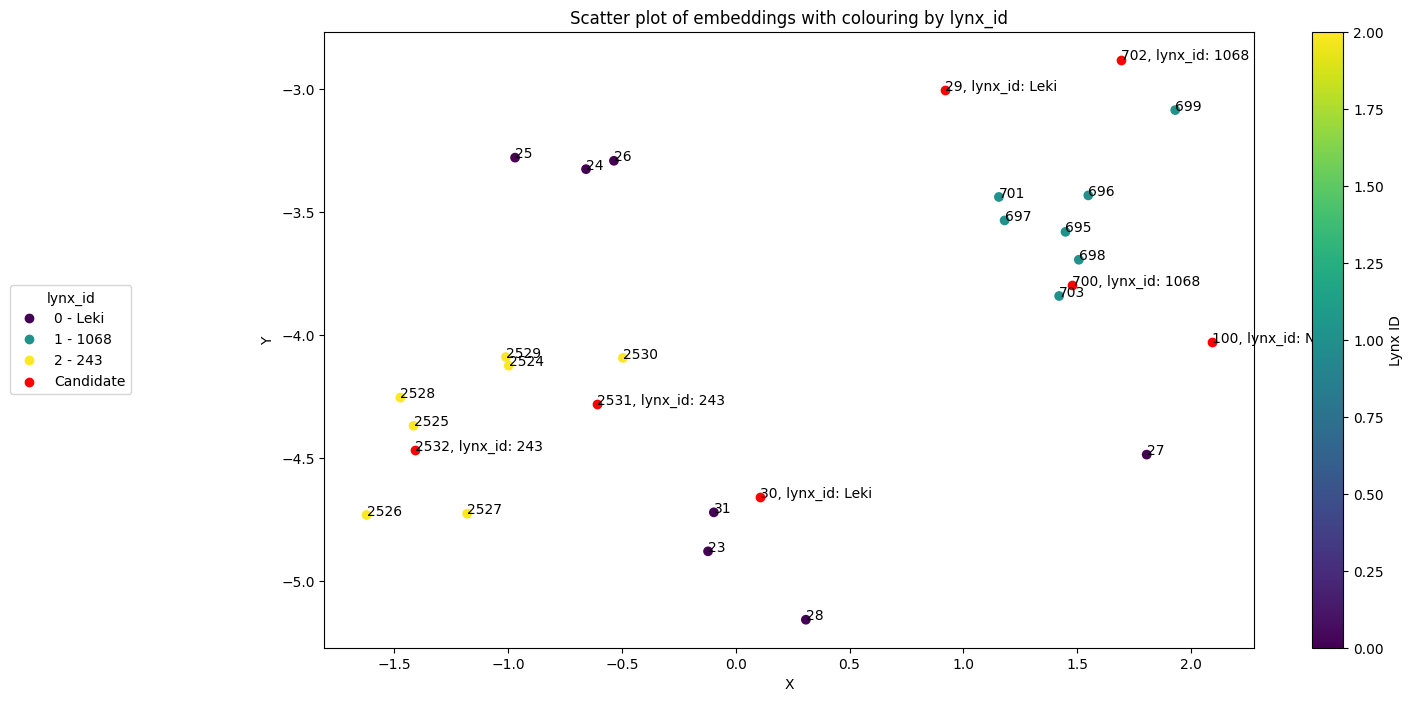

In [25]:
fig, ax = plt.subplots(figsize=(15, 8))

scatter = plt.scatter(data_knowledge['embedding_x'], data_knowledge['embedding_y'], c=data_knowledge['lynx_id_int'])
ax.scatter(data_candidates['embedding_x'], data_candidates['embedding_y'], c='red', marker='o', label='New data')

handles, labels = scatter.legend_elements()
handles.append(ax.scatter([], [], c='red', marker='o'))
labels.append('Candidate')

for i in data_knowledge.index.tolist():
    plt.annotate(data_knowledge.loc[i]['index'], (embeddings_2d[i, 0], embeddings_2d[i, 1]))

for i in data_candidates.index.tolist():
    plt.annotate(str(data_candidates.loc[i]['index']) + ", lynx_id: " + data_candidates.loc[i]['lynx_id'], (embeddings_2d[i, 0], embeddings_2d[i, 1]))
    
labels = [re.search(r'\d+', key).group() + ' - ' + lynx_int_to_str[int(re.search(r'\d+', key).group())] if re.search(r'\d+', key) else key for key in labels]
legend = ax.legend(handles, labels, loc="center right", title="lynx_id",  bbox_to_anchor=(-0.2, 0.5))

plt.colorbar(label="Lynx ID")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter plot of embeddings with colouring by lynx_id")
plt.savefig("embeddings.png")

### Nearest Neighbors

Computation with real embeddings, no t-SNE

In [50]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric="minkowski").fit(embeddings_knowledge)

In [51]:
distances, indices = neighbors.kneighbors(embeddings_candidates)
distances, indices

(array([[1.0921711 , 1.5813074 , 1.62936322, 1.63936327, 1.80049108],
        [0.2342509 , 0.47313067, 0.55411419, 0.75645069, 0.79374131],
        [0.54671522, 1.12092451, 1.13822544, 1.22643838, 1.53899349],
        [0.500334  , 0.6679992 , 0.84172033, 0.984582  , 0.98525441],
        [1.0095152 , 1.27513076, 1.77719686, 1.78164314, 2.065352  ],
        [1.63076932, 1.705546  , 1.73338626, 1.73917776, 1.85159167],
        [1.69317753, 1.79893044, 1.80339321, 1.81874606, 1.82616104]]),
 array([[11, 10,  8,  7,  9],
        [13,  7, 10,  9,  8],
        [20, 14, 19, 17, 18],
        [15, 18, 16, 14, 17],
        [ 6,  0, 20,  5, 14],
        [ 9, 12, 10,  7,  8],
        [13,  7, 10,  9,  8]]))

In [52]:
for candidate_indices in indices:
    print(candidate_indices)
    break

[11 10  8  7  9]


In [53]:
candidates_nearest_neighbors = [
    data_knowledge.iloc[candidate_indices]["lynx_id"]
    for candidate_indices in indices
]

candidates_nearest_neighbors

[13    1068
 12    1068
 10    1068
 9     1068
 11    1068
 Name: lynx_id, dtype: object,
 17    1068
 9     1068
 12    1068
 11    1068
 10    1068
 Name: lynx_id, dtype: object,
 24    243
 18    243
 23    243
 21    243
 22    243
 Name: lynx_id, dtype: object,
 19    243
 22    243
 20    243
 18    243
 21    243
 Name: lynx_id, dtype: object,
 8     Leki
 0     Leki
 24     243
 5     Leki
 18     243
 Name: lynx_id, dtype: object,
 11    1068
 15    1068
 12    1068
 9     1068
 10    1068
 Name: lynx_id, dtype: object,
 17    1068
 9     1068
 12    1068
 11    1068
 10    1068
 Name: lynx_id, dtype: object]

In [54]:
candidates_predicted_n_knn = [
    candidate.value_counts().idxmax() for candidate in candidates_nearest_neighbors
]

candidates_predicted_n_knn

['1068', '1068', '243', '243', 'Leki', '1068', '1068']

In [55]:
candidates_predicted_1_knn = [
    candidate.iloc[0] for candidate in candidates_nearest_neighbors
]

candidates_predicted_1_knn

['1068', '1068', '243', '243', 'Leki', '1068', '1068']

In [56]:
# True lynx_id
candidates_id = data_candidates.lynx_id.tolist()
candidates_id

['1068', '1068', '243', '243', 'Leki', 'Leki', 'New']

#### Should we reject the individual prediction? Is it a new individual?

In [57]:
cluster_variances = {cluster_indices: np.var(data_knowledge[data_knowledge['lynx_id_int'] == cluster_indices]['embedding'].to_list(), axis=0) for cluster_indices in [0, 1, 2]}
cluster_variances

{0: array([0.7174627 , 0.59344894], dtype=float32),
 1: array([0.05758999, 0.04854438], dtype=float32),
 2: array([0.12369812, 0.06857877], dtype=float32)}

In [58]:
cluster_means = {cluster_indices: np.mean(data_knowledge[data_knowledge['lynx_id_int'] == cluster_indices]['embedding'].to_list(), axis=0) for cluster_indices in [0, 1, 2]}
cluster_means

{0: array([-0.0378708, -4.1620326], dtype=float32),
 1: array([ 1.4558021, -3.514849 ], dtype=float32),
 2: array([-1.1697623, -4.3402867], dtype=float32)}

To **find the best value for sigma**, we can try to **find the value which maximises the true positives (rate of well classified known individuals) and the true negatives (rate of well classified unknown individuals)**.

In [59]:
confidence_levels = [0.68, 0.95, 0.99]

In [60]:
def compute_confidence_intervals(confidence, means, variances):
    intervals = []
    for mean, variance in zip(means.values(), variances.values()):
        interval = norm.interval(confidence, loc=mean, scale=np.sqrt(variance))
        intervals.append((np.array([interval[0][0], interval[1][0]]), np.array([interval[0][1], interval[1][1]])))
    
    return intervals

In [61]:
def check_new_individual(candidates_dots, candidates_predicted, candidates_id):
    candidates_predicted_local = candidates_predicted.copy()
    for index, (candidate_dot, candidate_predicted, candidate_id) in enumerate(zip(candidates_dots, candidates_predicted, candidates_id)):
        confidence_intervals_for_candidate = confidence_intervals[lynx_str_to_int[candidate_predicted]]

        in_confidence_interval = all(
            interval[0] <= dot <= interval[1]
            for dot, interval in zip(candidate_dot, confidence_intervals_for_candidate)
        )

        if in_confidence_interval:
            print(f"Candidate {candidate_dot} | Prediction: {candidate_predicted} | True label: {candidate_id}")
        else:
            print(f"Candidate {candidate_dot} | Prediction: new individual | True label: {candidate_id}")
            candidates_predicted_local[index] = "New"
        
    return candidates_predicted_local

In [62]:
def compute_accuracy(candidates_predicted, candidates_refs):
    correct_predictions = sum(p == r for p, r in zip(candidates_predicted, candidates_refs))

    total_predictions = len(candidates_predicted)
    accuracy = correct_predictions/total_predictions
    
    return accuracy

In [63]:
candidates_dots = data_candidates.embedding.tolist()
candidates_dots

[[1.6907772, -2.8808644],
 [1.4765469, -3.796697],
 [-0.6108885, -4.2800674],
 [-1.4075305, -4.467586],
 [0.1070639, -4.6587753],
 [0.91966265, -3.0046146],
 [2.0917974, -4.028076]]

In [64]:
accuracy_list = []

for confidence in confidence_levels:
    print("*"*50, confidence, "*"*50)
    confidence_intervals = compute_confidence_intervals(confidence, cluster_means, cluster_variances)
    candidates_predicted_check = check_new_individual(candidates_dots, candidates_predicted_1_knn, candidates_id)
    accuracy = compute_accuracy(candidates_predicted_check, candidates_id)
    print(f"Accuracy: {accuracy}")
    accuracy_list.append(accuracy)

************************************************** 0.68 **************************************************
Candidate [1.6907772, -2.8808644] | Prediction: new individual | True label: 1068
Candidate [1.4765469, -3.796697] | Prediction: new individual | True label: 1068
Candidate [-0.6108885, -4.2800674] | Prediction: new individual | True label: 243
Candidate [-1.4075305, -4.467586] | Prediction: 243 | True label: 243
Candidate [0.1070639, -4.6587753] | Prediction: Leki | True label: Leki
Candidate [0.91966265, -3.0046146] | Prediction: new individual | True label: Leki
Candidate [2.0917974, -4.028076] | Prediction: new individual | True label: New
Accuracy: 0.42857142857142855
************************************************** 0.95 **************************************************
Candidate [1.6907772, -2.8808644] | Prediction: new individual | True label: 1068
Candidate [1.4765469, -3.796697] | Prediction: 1068 | True label: 1068
Candidate [-0.6108885, -4.2800674] | Prediction: 243 

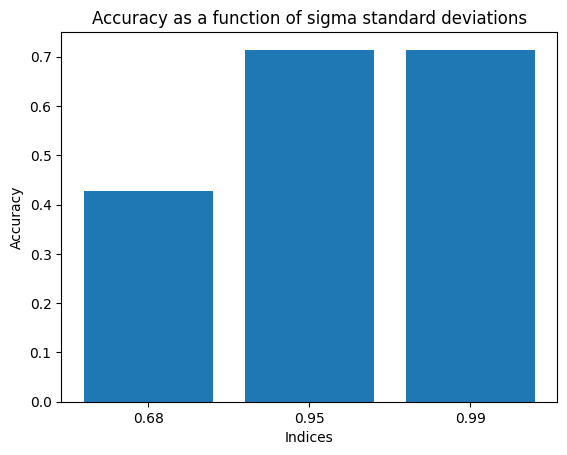

In [65]:
plt.bar([str(conf) for conf in confidence_levels], accuracy_list)
plt.xlabel('Indices')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of sigma standard deviations')
plt.show()

### Compute the other metrics

Now let's calculate the metrics. To do this, we use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k**, **mAP@k** and **Precision@k**. 

Before calculating the metrics, we need to **adapt `candidates_nearest_neighbors` to the detection of new individuals after our calculation with confidence intervals**. Candidate i, if detected as New, will see its neighbours as "New" from now on.

In [66]:
for index, value in enumerate(candidates_predicted_check):
    if value == "New":
        candidates_nearest_neighbors[index] = candidates_nearest_neighbors[index].apply(lambda x: "New")
        
candidates_nearest_neighbors

[13    New
 12    New
 10    New
 9     New
 11    New
 Name: lynx_id, dtype: object,
 17    1068
 9     1068
 12    1068
 11    1068
 10    1068
 Name: lynx_id, dtype: object,
 24    243
 18    243
 23    243
 21    243
 22    243
 Name: lynx_id, dtype: object,
 19    243
 22    243
 20    243
 18    243
 21    243
 Name: lynx_id, dtype: object,
 8     Leki
 0     Leki
 24     243
 5     Leki
 18     243
 Name: lynx_id, dtype: object,
 11    1068
 15    1068
 12    1068
 9     1068
 10    1068
 Name: lynx_id, dtype: object,
 17    New
 9     New
 12    New
 11    New
 10    New
 Name: lynx_id, dtype: object]

In [67]:
top_k = (1, 2, 3, 4, 5)

In [68]:
def acc_k_list(nearest_individuals, true_individual):
    return nearest_individuals.apply(lambda x: x == true_individual).tolist()

In [69]:
candidates_acc_k_list = [acc_k_list(neighbors, candidate_id) for neighbors, candidate_id in zip(candidates_nearest_neighbors, candidates_id)]
candidates_acc_k_tensor = torch.tensor(candidates_acc_k_list, dtype=torch.bool)

candidates_acc_k_tensor

tensor([[False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, False,  True, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True]])

#### CMC@k (Cumulative Matching Characteristics) 

In [70]:
calc_cmc(candidates_acc_k_tensor, top_k)

[tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 1., 1., 0., 1.])]

#### mAP@k (mean Average Precision)

In [71]:
n_gt = torch.tensor([5])

In [72]:
calc_map(candidates_acc_k_tensor, n_gt=n_gt, top_k=top_k)

[tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 0.9167, 0.0000, 1.0000]),
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 0.9167, 0.0000, 1.0000])]

#### Precision@k

In [73]:
calc_precision(candidates_acc_k_tensor, n_gt=n_gt, top_k=top_k)

[tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 1., 1., 0., 1.]),
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 0.6667, 0.0000, 1.0000]),
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 0.7500, 0.0000, 1.0000]),
 tensor([0.0000, 1.0000, 1.0000, 1.0000, 0.6000, 0.0000, 1.0000])]